# Imports

In [1]:
# Imports
from   IPython.display import display, HTML
import os
import h5py
import pandas as pd, datetime as dt, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from   pandas.tseries.offsets import DateOffset
import sys


# Display options
thisnotebooksys = sys.stdout
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [2]:
import mimicLOB as lob
from mimicLOB.orderbook.orderbook import OrderBook
from mimicLOB.agent.replayerAgent import replayerAgent

## LOB creation

In [3]:
# b_tape = True means the LOB 
LOB = OrderBook(tick_size  = 0.5, 
                b_tape     = True,
                b_tape_LOB = True,
                verbose    = False)

## Data

- DTIME : le timestamp de l'ordre ;
- ORDER_ID : l'identifiant de l'ordre (que tu peux suivre en cas de changement dans la journée) ;
- PRICE 
- QTY
- ORDER_SIDE
- ITM : identifiant du trader
- ORDER_SIDE
- ORDER_TYPE :  <br>1 pour Market Order; <br>2 pour Limit Order; <br>q pour Quote <br> W pour Market On Open;
- ORDER_DURATION
- ACCOUNT_TYPE : type de client;
- PRODUCT_NAME : le nom du future et donc la maturité;
- SHORT_NAME : Maturité
- MONTHS_TO_EXPIRY
- INSTRUMENT_TYPE : F pour Future
- ACTION_TYPE : <br> I = limit order insertion (passive); <br> C = limit order cacnellations; <br> R = replace order that lose priority; <br> r = replace order that keeps priority; <br> S = replace order that makes the order aggressive (give rise to trade); <br> T = aggressive order (give rise to trade)
- MATCH_STRATEGY : True/False
- IS_OPEN_TRADE :  True/False
- BIDi, i=0,...,14 : prix bid à la i-ième limite du best bid
- BIDi_QTY, i=0,...,14 : quantité à la i-ième limite du best bid
- ASKi, i=0,...,14 : prix ask à la i-ième limite du best ask
- ASKi_QTY, i=0,...,14 : quantité à la i-ième limite du best ask
- SIGN : -1/1
- FRONT : True/False

In [4]:
df = pd.read_hdf(r'data\day20160428.h5')

# Filters
ProductName = "JFFCE160500000F"
cols = ['DTIME', 'ORDER_ID', 'PRICE', 'QTY', 'ORDER_SIDE', 'ORDER_TYPE',
        'ORDER_DURATION', 'ACTION_TYPE', 'MATCH_STRATEGY', 'IS_OPEN_TRADE']

# Filter 
df = df[df.PRODUCT_NAME=="JFFCE160500000F"]
df = df[cols]

#Vizu
df.tail()

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
1656551,2016-04-28 21:15:00.624695,434884337166781043,4424.0,110,B,2,6,C,False,False
1656552,2016-04-28 21:15:00.624707,434884337166791567,4410.0,1,B,2,6,C,False,False
1656553,2016-04-28 21:15:00.624892,434884337166868579,4500.0,1,S,2,6,C,False,False
1656554,2016-04-28 21:15:00.624901,434884337166950905,4519.0,10,S,2,6,C,False,False
1656555,2016-04-28 21:15:00.625726,434884337167238674,4354.5,2,B,2,6,C,False,False


In [5]:
df[df.ORDER_ID==434884337166455340]

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
24269,2016-04-28 07:30:22.142112,434884337166455340,4472.0,24,S,2,3,T,False,False


## Agent Creation

In [6]:
myself_config = {'orderbook'        : LOB,
                 'id'               : 'Fayçal',
                 'b_record'         : False,
                 'historicalOrders' : df}
replayer = replayerAgent(**myself_config)

## Replay orders

Takes about 3min

In [7]:
#log
f = open('log.txt','w'); 
sys.stdout = f

In [8]:
%%time
replayer.replayOrders()

KeyboardInterrupt: 

In [9]:
sys.stdout = thisnotebooksys

In [8]:
# import xlwings
# xlwings.view(df.iloc[0:1000000, :])
# xlwings.view(df.iloc[1000001:, :])

## Get the LOB state

In [26]:
LOBstate = replayer.getLOBState()

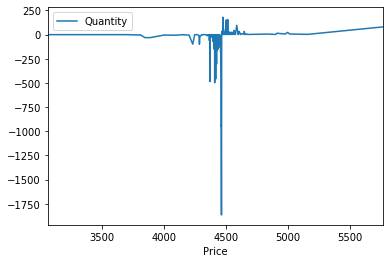

In [14]:
LOBstate.set_index('Price').sort_index().plot()

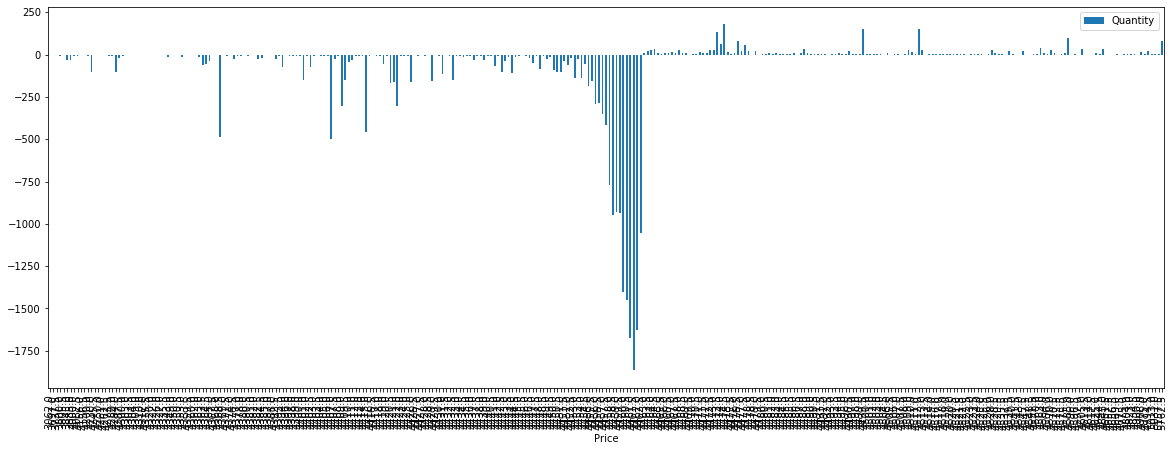

In [27]:
LOBstate_ = LOBstate.set_index('Price').sort_index()
tick_size = float(LOB.tick_size)
minPrice  = float(LOB.bids.min_price())
maxPrice  = float(LOB.bids.max_price())
# LOBstate_ = LOBstate_.reindex(np.arange(minPrice, maxPrice+tick_size, tick_size))
LOBstate_.plot.bar(figsize=(20, 7))
plt.show()

## Get Price Tape

'open : 4503.0'

'high : 4514.0'

'low : 4436.5'

'close : 4444.0'

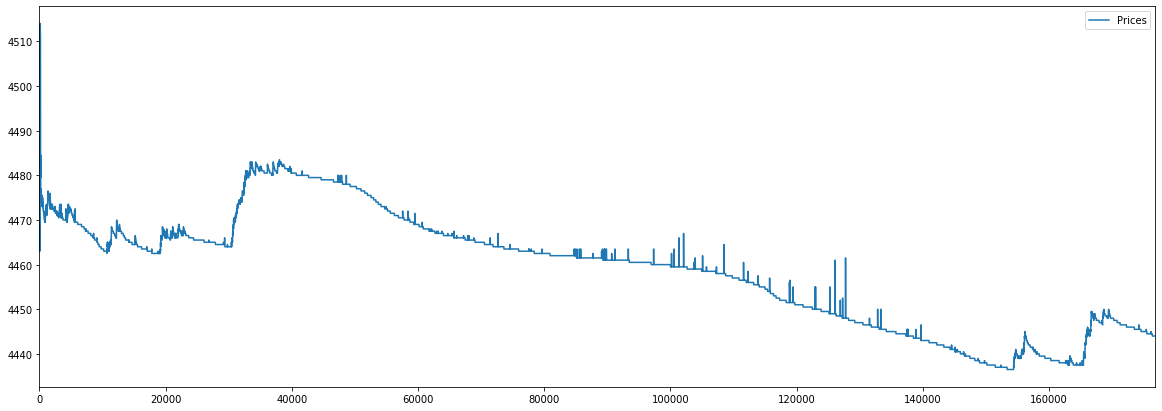

In [9]:
histoPrices = replayer.getPriceTape().astype(float)
histoPrices.plot(figsize=(20,7))

# OHLC
display(f'open : {histoPrices.iloc[0,0]}')
display(f'high : {histoPrices.max()[0]}')
display(f'low : {histoPrices.min()[0]}')
display(f'close : {histoPrices.iloc[-1, 0]}')

plt.show()

## Get Transaction Tape

In [17]:
TransactionTape = replayer.getTransactionTape()

In [18]:
TransactionTape

,time,party1_id,party1_side,party1_order_id,party2_id,party2_side,party2_order_id,traded_price,traded_quantity
0,1586701087819171200,Fayçal,ask,434884337166434880,Fayçal,ask,434884337166434924,4503,1
1,1586701087824157900,Fayçal,bid,434884337166434943,Fayçal,bid,434884337166434964,4503.5,1
2,1586701087824157900,Fayçal,bid,434884337166434945,Fayçal,bid,434884337166434964,4501,1
3,1586701087824157900,Fayçal,bid,434884337166434941,Fayçal,bid,434884337166434964,4500,4
4,1586701087824157900,Fayçal,bid,434884337166434913,Fayçal,bid,434884337166434966,4496.5,6
...,...,...,...,...,...,...,...,...,...
18252,1586701103286312700,Fayçal,bid,434884337166479798,Fayçal,bid,434884337166508872,4462.5,1
18253,1586701103286312700,Fayçal,bid,434884337166479836,Fayçal,bid,434884337166508872,4462.5,2
18254,1586701103286312700,Fayçal,bid,434884337166479875,Fayçal,bid,434884337166508872,4462.5,1
18255,1586701103290302000,Fayçal,bid,434884337166479880,Fayçal,bid,434884337166508889,4462.5,1


In [22]:
df[df.ORDER_ID==434884337166434952]

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
130,2016-04-28 06:30:00.359595,434884337166434952,4466.5,25,B,2,0,I,False,False
230,2016-04-28 06:50:18.378401,434884337166434952,4421.5,25,B,2,0,R,False,False
15214,2016-04-28 07:15:21.437291,434884337166434952,4458.5,25,B,2,0,R,False,False


In [25]:
df[df.ORDER_ID==434884337166435018]

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
220,2016-04-28 06:49:56.115903,434884337166435018,4463.0,39,S,2,0,I,False,True


In [20]:
TransactionTape[TransactionTape.party1_order_id==434884337166434952]

,time,party1_id,party1_side,party1_order_id,party2_id,party2_side,party2_order_id,traded_price,traded_quantity
41,1586701087833133900,Fayçal,bid,434884337166434952,Fayçal,bid,434884337166435018,4466.5,25


In [23]:
TransactionTape[TransactionTape.party1_order_id==434884337166435018]

,time,party1_id,party1_side,party1_order_id,party2_id,party2_side,party2_order_id,traded_price,traded_quantity
49,1586701087852083200,Fayçal,ask,434884337166435018,Fayçal,ask,434884337166435110,4463,3


In [ ]:
for trade in LOB.tape:
    if trade['party2_order_id']==434884337166442982:
        print(trade)
        exit

## Get LOB Tape 

The LOB tape is the state of the LOB before each order arrival

In [9]:
LOBtape = replayer.getLOBTape()

In [10]:
import xlwings 
xlwings.view(LOBtape.loc[0:10000,:])

In [13]:
xlwings.view(df.loc[0:2000,:])